In [1]:
import torch
from torchvision.io import read_image, ImageReadMode, write_video
import torchvision.transforms as T
from random import randint
from IPython.display import clear_output
import numpy as np
import pylab as pl

from src import *

N_CHANNELS = 16        # Number of CA state channels
TARGET_PADDING = 8     # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
POOL_SIZE = 512
CELL_FIRE_RATE = 0.5
cuda=torch.device('cuda')

In [2]:
from scipy.stats import truncexpon


def train_CA(CA: NeuralCA,
             growing: NeuralCA,
             optimizer: torch.optim.Optimizer,
             criterion: Callable[[torch.Tensor], Tuple[torch.Tensor, torch.Tensor]],
             pool: SamplePool,
             n_epochs: int,
             scheduler: torch.optim.lr_scheduler._LRScheduler = None,
             batch_size: int = 4,
             skip_update: int = 2,
             evolution_iters: Tuple[int, int] = (50, 60),
             kind: str = "growing",
             **kwargs):

    CA.train()
    growing.eval()

    for i in range(n_epochs):
        epoch_losses = []  # array that stores the loss history

        # take the data
        for j in range(pool.size // batch_size):
            inputs, indexes = pool.sample(batch_size)  # sample the inputs
            inputs = inputs.to(CA.device)  # put them in the current device
            optimizer.zero_grad()  # reinitialize the gradient to zero

            # Evolve the growing
            total_iters = randint(*evolution_iters)
            growing_iters = (truncexpon.rvs(2)*25).astype(int)

            inputs = growing.evolve(inputs, growing_iters)

            # recursive forward-pass
            for k in range(randint(*evolution_iters)):
                inputs = CA.forward(inputs)

            # calculate the loss of the inputs and return the one with the biggest loss
            loss, idx_max_loss = criterion(inputs)
            # add current loss to the loss history
            epoch_losses.append(loss.item())

            # look a definition of skip_update
            if j % skip_update != 0:
                idx_max_loss = None

            # backward-pass
            loss.backward()
            optimizer.step()

            # customization of training for the three processes of growing.
            # persisting and regenerating
            # if regenerating, then damage inputs
            if kind == "regenerating":
                inputs = inputs.detach()
                try:
                    target_size = kwargs['target_size']
                except KeyError:
                    target_size = None
                    print('missing argument "target_size" in the kwargs')
                try:
                    constant_side = kwargs['constant_side']
                except KeyError:
                    constant_side = None
                    print('missing argument "constant_side" in the kwargs')
                # damages the inputs by removing square portions
                inputs = make_squares(
                    inputs, target_size=target_size, constant_side=constant_side)

            # if training is not for growing proccess then re-insert
            # trained/damaged samples into the pool
            if kind != "growing":
                pool.update(inputs, indexes, idx_max_loss)

        # update the scheduler if there is one at all
        if scheduler is not None:
            scheduler.step()

        regenerating.losses.append(np.mean(epoch_losses))
        print(f"epoch: {i+1}\navg loss: {np.mean(epoch_losses)}")
        clear_output(wait=True)


In [3]:
growing=NeuralCA(N_CHANNELS)
regenerating=NeuralCA(N_CHANNELS)
regenerating.device

growing.load_state_dict(torch.load('Pretrained_models/firework_growing.pt', map_location=cuda))
# regenerating.load_state_dict(torch.load('Pretrained_models/firework_regenerating.pt', map_location=cuda))

growing.to(cuda)
regenerating.to(cuda)

NeuralCA(
  (layers): Sequential(
    (0): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
  )
)

# Without training the regenerating part
Without any training on the regenerating part the image fails to converge and persist to the final form

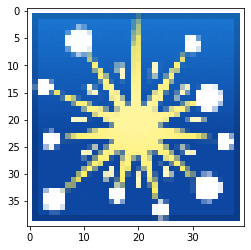

In [4]:
target = read_image("images/firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

target = target.to(cuda)

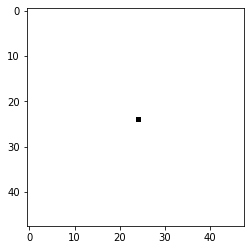

In [5]:
pool = SamplePool(POOL_SIZE, N_CHANNELS, IMAGE_SIZE)
imshow(pool[0])

In [9]:
regenerating.save("growing_part_2.pt")

Successfully saved model!


In [8]:
# Train the model
for param in growing.parameters():
    param.requires_grad = False

torch.backends.cudnn.benchmark = True # Speeds up training
optimizer = torch.optim.Adam(regenerating.parameters(), lr=2e-3*0.3)
criterion = NCALoss(pad(target, TARGET_PADDING), torch.nn.MSELoss)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80], gamma=0.3)
train_CA(regenerating, growing, optimizer, criterion, pool, batch_size=4, n_epochs=300, scheduler=scheduler, kind="growing")

KeyboardInterrupt: 

In [ ]:
switch=5 #the amount of steps before switching from growing to regenerating
video, initial_state=make_video(growing,switch)
_=make_video(regenerating,200,initial_state,fname='switch'+str(switch)+'.mkv', initial_video=video)